In [24]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

In [25]:
# 텍스트 데이터 로딩
df = pd.read_csv('../11th_project/naver_shopping.txt', sep="\t", names=["sentiment_four", "review"])

# 감정 점수 1, 2 → 부정(0), 4, 5 → 긍정(1) 으로 이진 분류 레이블 변경
df = df[df['sentiment_four'].isin([1, 2, 4, 5])]
df['sentiment'] = df['sentiment_four'].replace({1: 0, 2: 0, 4: 1, 5: 1})

In [26]:
df['sentiment'].value_counts()

sentiment
0    25229
1    24771
Name: count, dtype: int64

<Axes: xlabel='sentiment_four'>

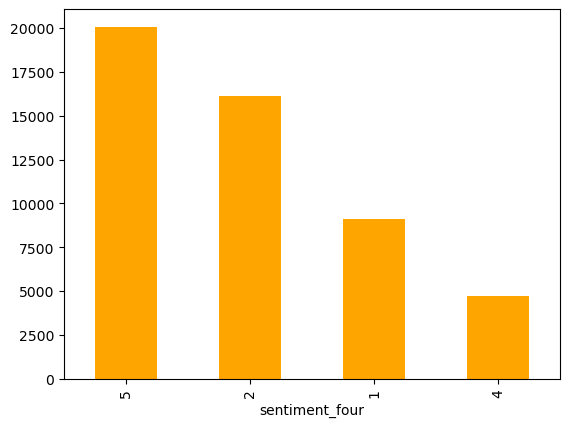

In [27]:
df['sentiment_four'].value_counts().plot(kind='bar', color = 'orange')

<Axes: xlabel='sentiment'>

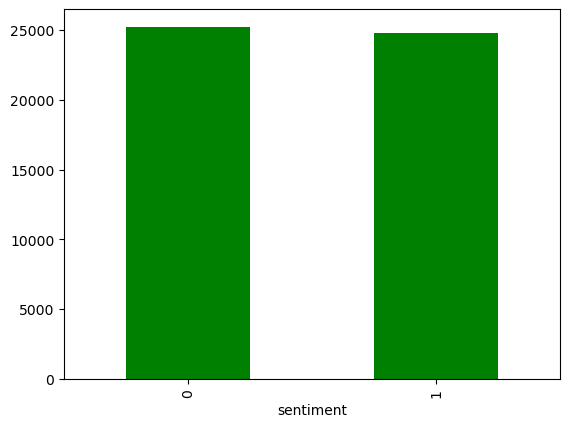

In [28]:
df['sentiment'].value_counts().plot(kind='bar', color = 'green')

In [29]:
# 전처리 함수 정의
okt = Okt()
stopwords = set([
    '의','가','이','은','들','는','좀','잘','걍','과','도','를',
    '으로','자','에','와','한','하다','있다','되다','되','이렇다'
])

# 리뷰 텍스트 전처리 함수 정의
def preprocess_korean_text(text):
    text = str(text).lower()                                  # 소문자 변환
    text = re.sub(r"\d+", "", text)                           # 숫자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)   # 특수문자, 이모티콘, 구두점 제거
    tokens = okt.morphs(text, stem=True)                      # 형태소 분석 + 어간 추출
    tokens = [t for t in tokens if t not in stopwords]        # 불용어 제거
    return tokens

# 전체 데이터 토큰화
def tokenize(sentences):
    return [preprocess_korean_text(sent) for sent in tqdm(sentences, desc="Tokenizing")]

tokenized_data = tokenize(df['review'].tolist())

Tokenizing: 100%|██████████| 50000/50000 [01:36<00:00, 518.25it/s]


In [30]:
# 모든 토큰을 하나의 리스트로 결합
word_list = [word for sent in tokenized_data for word in sent]

# 단어 빈도 수 계산
word_counts = Counter(word_list)

# 빈도순으로 정렬된 단어 리스트 생성 (단어 등장 3회 이상만 사용)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab = [w for w in vocab if word_counts[w] >= 3]

# 단어 → 인덱스 사전 생성
word_to_index = {'<PAD>': 0, '<UNK>': 1}
for idx, word in enumerate(vocab):
    word_to_index[word] = idx + 2
vocab_size = len(word_to_index)

In [31]:
# 단어 인덱스 시퀀스로 변환
def texts_to_sequences(tokenized_data, word_to_index):
    return [[word_to_index.get(w, 1) for w in sent] for sent in tokenized_data]

encoded_data = texts_to_sequences(tokenized_data, word_to_index)

In [32]:
# 시퀀스를 동일 길이(30)로 패딩
def pad_sequences(sequences, max_len=30):
    padded = np.zeros((len(sequences), max_len), dtype=int)
    for i, seq in enumerate(sequences):
        padded[i, :len(seq[:max_len])] = np.array(seq[:max_len])
    return padded

padded_data = pad_sequences(encoded_data, max_len=30)

In [33]:
# 학습/검증/테스트셋 분리 (비율: 50/40/10)
X_train, X_test, y_train, y_test = train_test_split(
    padded_data, df['sentiment'], test_size=0.5, random_state=0, stratify=df['sentiment'])
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [34]:
print('--------훈련 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_valid.value_counts()[0]/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_valid.value_counts()[1]/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------훈련 데이터의 비율-----------
부정 리뷰 = 50.455%
긍정 리뷰 = 49.545%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.46%
긍정 리뷰 = 49.54%
--------테스트 데이터의 비율-----------
부정 리뷰 = 50.46%
긍정 리뷰 = 49.54%


In [35]:
# PyTorch 텐서로 변환
train_tensor = torch.tensor(X_train, dtype=torch.long)
valid_tensor = torch.tensor(X_valid, dtype=torch.long)
test_tensor = torch.tensor(X_test, dtype=torch.long)

y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.long)
y_valid_tensor = torch.tensor(np.array(y_valid), dtype=torch.long)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long)

# 데이터로더 구성
train_loader = DataLoader(TensorDataset(train_tensor, y_train_tensor), batch_size=32, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_tensor, y_valid_tensor), batch_size=1, shuffle=False)
test_loader = DataLoader(TensorDataset(test_tensor, y_test_tensor), batch_size=1, shuffle=False)

In [36]:
# CNN 기반 텍스트 분류 모델
class CNN(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 128, padding_idx=0)
        self.conv1 = nn.Conv1d(128, 256, 5)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_labels)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv1(x)).permute(0, 2, 1).max(1)[0]
        x = self.dropout(x)
        return self.fc(x)

In [37]:
# 학습 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(vocab_size, num_labels=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
# 정확도 계산 함수
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).sum().item() / labels.size(0)

# 평가 함수 (손실, 정확도, 예측값 등 계산)
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, total_correct, total_len = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            total_correct += calculate_accuracy(outputs, y_batch) * y_batch.size(0)
            total_len += y_batch.size(0)
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return total_loss / len(dataloader), total_correct / total_len, all_preds, all_labels

In [39]:

best_val_loss = float('inf')
patience = 5
epochs = 30
no_improve = 0

for epoch in range(epochs):
    model.train()
    total_loss, total_correct, total_len = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += calculate_accuracy(outputs, y_batch) * y_batch.size(0)
        total_len += y_batch.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_len

    val_loss, val_accuracy, _, _ = evaluate(model, valid_loader, criterion)

    # 로그 출력
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "cnn_best_model.pt")
        print("Model improved. Saved.")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

Epoch 1/30:
Train Loss: 0.4619, Train Accuracy: 0.7868
Validation Loss: 0.3927, Validation Accuracy: 0.8272
Model improved. Saved.
Epoch 2/30:
Train Loss: 0.3333, Train Accuracy: 0.8629
Validation Loss: 0.3346, Validation Accuracy: 0.8592
Model improved. Saved.
Epoch 3/30:
Train Loss: 0.2681, Train Accuracy: 0.8939
Validation Loss: 0.3330, Validation Accuracy: 0.8664
Model improved. Saved.
Epoch 4/30:
Train Loss: 0.2272, Train Accuracy: 0.9123
Validation Loss: 0.3808, Validation Accuracy: 0.8544
Epoch 5/30:
Train Loss: 0.1907, Train Accuracy: 0.9289
Validation Loss: 0.3634, Validation Accuracy: 0.8612
Epoch 6/30:
Train Loss: 0.1620, Train Accuracy: 0.9412
Validation Loss: 0.3895, Validation Accuracy: 0.8652
Epoch 7/30:
Train Loss: 0.1368, Train Accuracy: 0.9497
Validation Loss: 0.4167, Validation Accuracy: 0.8656
Epoch 8/30:
Train Loss: 0.1143, Train Accuracy: 0.9573
Validation Loss: 0.4479, Validation Accuracy: 0.8644
Early stopping.


In [40]:
# 저장된 모델 불러와서 테스트셋 평가
model.load_state_dict(torch.load("cnn_best_model.pt"))
model.to(device)
_, _, test_preds, test_labels = evaluate(model, test_loader, criterion)

print("\n 성능 평가 (Test Set):")
print(classification_report(test_labels, test_preds, target_names=['부정', '긍정']))


 성능 평가 (Test Set):
              precision    recall  f1-score   support

          부정       0.86      0.89      0.87     12615
          긍정       0.88      0.85      0.86     12385

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [41]:
index_to_tag = {
    0: "부정",
    1: "긍정"
}

In [42]:
# 입력 문장 예측 함수
def predict(text):
    model.eval()
    tokens = preprocess_korean_text(text)
    indices = [word_to_index.get(t, 1) for t in tokens]
    
    # 최소 길이 보장: 30으로 패딩
    max_len = 30
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        predicted = torch.argmax(output, dim=1)
        return index_to_tag[predicted.item()]


In [43]:
print(predict("별루"))

부정
